In [1]:
import numpy as np

# Back-propagation example -- linear regression

## Generate Data

Generative model: linear model $\mathrm{\mathbf{Y}} = \mathrm{\mathbf{X}} \mathrm{\mathbf{W}}$

where
$\mathrm{\mathbf{X}} = \begin{bmatrix} \mathbf{x}_1^T \\ \vdots \\ \mathbf{x}_N^T \end{bmatrix}$, 
$\mathrm{\mathbf{Y}} = \begin{bmatrix} \mathbf{y}_1^T \\ \vdots \\ \mathbf{y}_N^T \end{bmatrix}$, 
$\mathrm{\mathbf{W}} = \begin{bmatrix} \mathbf{w}_1 & \cdots & \mathbf{w}_M \end{bmatrix}$

In [2]:
# Data dimensions
N = 1000 # number of data
D = 10   # feature dimension
M = 5    # target dimension

def get_data():
    np.random.seed(0)

    eps = 0.01
    sparsity = 0.5

    W = np.random.randn(D, M)
    mask = np.random.rand(*W.shape) < sparsity
    W[mask] = 0 # make W sparse (contain many zeroes)
    
    X = np.random.randn(N, D)
    Y = X @ W + eps * np.random.randn(N, M) # add random noise
    return X, Y, W

In [3]:
X, Y, W_truth = get_data()
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("W shape:", W_truth.shape)

X shape: (1000, 10)
Y shape: (1000, 5)
W shape: (10, 5)


## Loss

- Least squares loss: $l_2 = \dfrac{1}{2}\lVert \mathrm{\mathbf{Y}} - \mathrm{\mathbf{X}} \mathrm{\mathbf{W}} \rVert_F^2$
- L-1 norm regularization: $l_1 = \displaystyle\sum_{i=1}^N \lVert \mathbf{w}_i \rVert_1 = \sum_{i=1}^N \sum_{j=1}^D |w_{ij}|$

## Computational graph

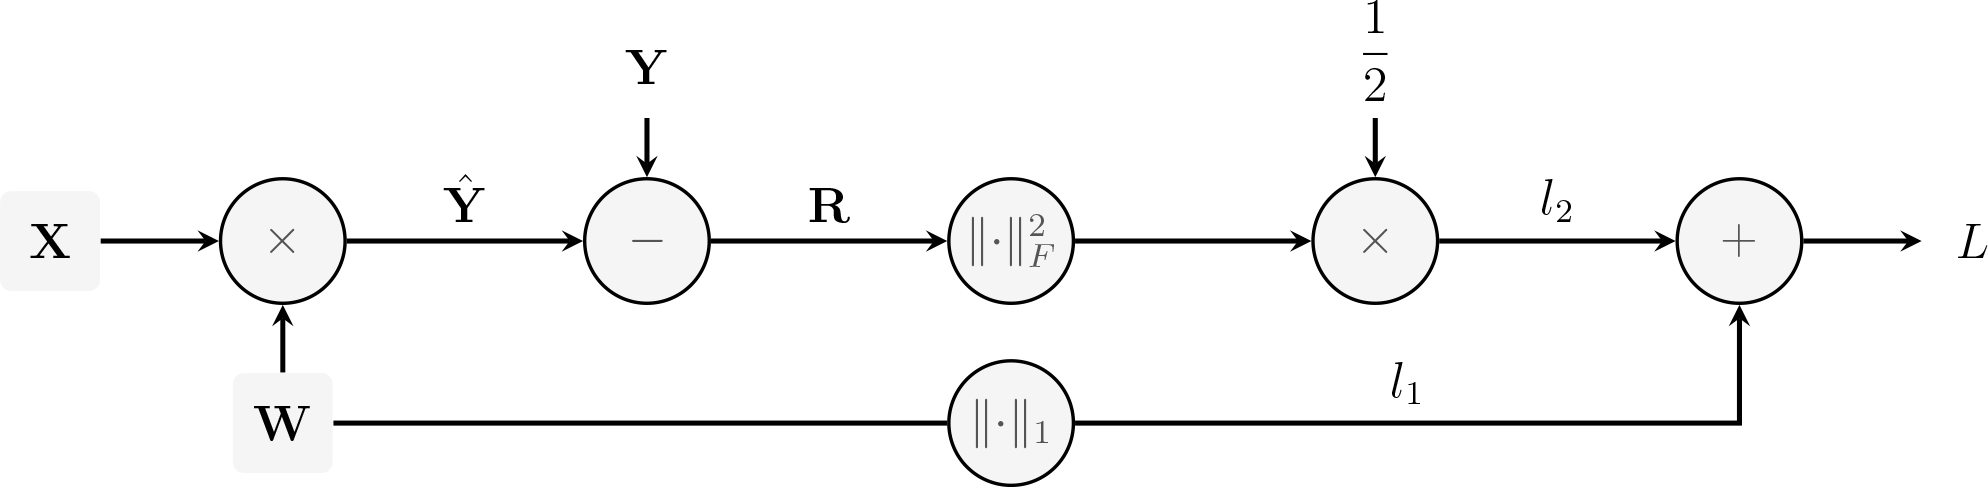

## Derivative by back-propagation

- Addition gate: $L = l_1 + l_2$

  $\dfrac{\partial L}{\partial l_1} = 1$, $\dfrac{\partial L}{\partial l_2} = 1$

In [4]:
def add_forward(A, B):
    out = A + B
    cache = {}
    return out, cache

def add_backward(dout, cache):
    dA = dout
    dB = dout
    return dA, dB

<hr>
- Subtraction gate: $\mathrm{\mathbf{M}} = \mathrm{\mathbf{A}} - \mathrm{\mathbf{B}}$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{A}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{B}}} = -\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

In [5]:
def minus_forward(A, B):
    out = A - B
    cache = {}
    return out, cache

def minus_backward(dout, cache):
    dA = dout
    dB = -dout
    return dA, dB

<hr>
- Multiplication gate: $\mathrm{\mathbf{M}} = \mathrm{\mathbf{A}} \mathrm{\mathbf{B}}$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{A}}} = \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} \mathrm{\mathbf{B}}^T$
  
  $\dfrac{\partial L}{\partial \mathrm{\mathbf{B}}} = \mathrm{\mathbf{A}}^T \dfrac{\partial L}{\partial \mathrm{\mathbf{M}}}$

In [6]:
def mul_forward(A, B):
    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        out = A @ B
    elif isinstance(A, float) and isinstance(B, float):
        out = A * B
    else:
        raise ValueError("Unsupported A and/or B")
    cache = {"A": A, "B": B}
    return out, cache

def mul_backward(dout, cache):
    A, B = cache["A"], cache["B"]
    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        dA = dout @ B.T
        dB = A.T @ dout
    elif isinstance(A, float) and isinstance(B, float):
        dA = dout * B
        dB = dout * A
    else:
        raise ValueError("Unsupported A and/or B")
    return dA, dB

<hr>
- Frobenius norm gate: $l = \lVert\mathrm{\mathbf{M}}\rVert_F^2$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} = 2\dfrac{\partial L}{\partial l} \mathrm{\mathbf{M}}$

In [7]:
def frobenius_norm_square_forward(M):
    cache = {"M": M}
    out = (M ** 2).sum()
    return out, cache

def frobenius_norm_square_backward(dout, cache):
    return 2 * dout * cache["M"]

<hr>
- L-1 norm gate: $l = \displaystyle \sum_{i=1}^N \sum_{j=1}^D |M_{ij}|$

  $\dfrac{\partial L}{\partial \mathrm{\mathbf{M}}} = \dfrac{\partial L}{\partial l} \dfrac{\partial l}{\partial \mathrm{\mathbf{M}}}$

  $\left(\dfrac{\partial l}{\partial \mathrm{\mathbf{M}}}\right)_{ij} = \begin{cases} 1 & M_{ij} > 0 \\ -1 & M_{ij} < 0 \\ 0 & \text{otherwise}  \end{cases}$

In [8]:
def l1_norm_forward(M):
    cache = {"M": M}
    out = np.abs(M).sum()
    return out, cache

def l1_norm_backward(dout, cache):
    M = cache["M"]
    dl_dM = (M > 0).astype("float") - (M < 0).astype("float")
    return dout * dl_dM

### Forward pass

In [9]:
def forward(W):
    Yhat, mul_1_cache = mul_forward(X, W)
    R, minus_cache = minus_forward(Yhat, Y)
    l2_double, fro_cache = frobenius_norm_square_forward(R)
    l2, mul_2_cache = mul_forward(l2_double, 0.5)

    l1, l1_cache = l1_norm_forward(W)

    L, add_cache = add_forward(l1, l2)

    cache = {
        "mul_1_cache": mul_1_cache,
        "minus_cache": minus_cache,
        "fro_cache": fro_cache,
        "mul_2_cache": mul_2_cache,
        "l1_cache": l1_cache,
        "add_cache": add_cache
    }
    return L, cache

### Backward pass

In [10]:
def backward(cache):
    dL = 1 / N
    dl1, dl2 = add_backward(dL, cache["add_cache"])

    dl2_double, _ = mul_backward(dl2, cache["mul_2_cache"])

    dW_l1 = l1_norm_backward(dl1, cache["l1_cache"])

    dR = frobenius_norm_square_backward(dl2_double, cache["fro_cache"])
    
    dYhat, dY = minus_backward(dR, cache["minus_cache"])
    dX, dW_l2 = mul_backward(dYhat, cache["mul_1_cache"])

    dW = dW_l1 + dW_l2
    return dW, dX

### Gradient descent

In [11]:
# randomly initialize the parameters W
W = np.random.randn(*W_truth.shape)

step_size = 0.1
for step in range(100):
    L, cache = forward(W)
    dW, dX = backward(cache)
    W += -step_size * dW
    if step % 10 == 0:
        print(L)

36290.385171245536
4493.330681021622
601.1856682872633
100.36237108187053
32.52772972887787
22.858887362068536
21.41741157081782
21.195916267630857
21.16324131701643
21.16090781463644


### Compare with ground truth

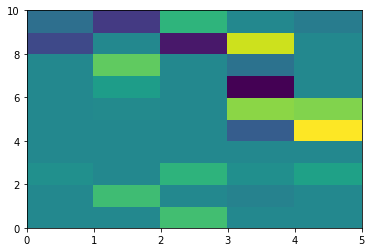

In [12]:
from matplotlib import pyplot as plt
plt.pcolor(W)

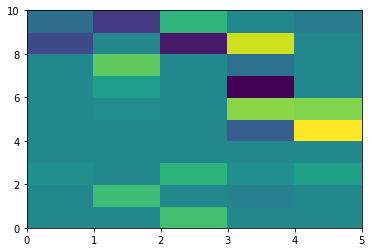

In [13]:
plt.pcolor(W_truth)

# Derivative when there is broadcasting

```python
N = 100 # number of data points
C = 10 # number of classes
A = np.random.randn(N, C)
b = np.random.randn(C)
Z = A + b
```

Suppose we know `dZ` ($\dfrac{\partial L}{\partial \mathrm{\mathbf{Z}}}$), what is `db` ($\dfrac{\partial L}{\partial \mathbf{b}}$)?

- `db = dZ`? Even the shape doesn't match!
- `db = dZ.sum(axis=0)` sum over the axis where the broadcasting happened